# CS 190H/292H Midterm
### Approximating the Sigmoid activation function by way of transition probability response function
Firstly, it's important we define some basic functions. We need not implement a circuit just yet, as we can model everything as some basic matrix multiplication functions. <br>
We need to make:
1. A rotation gate
2. A unitary as a composite of equiangular rotation gates
3. The transition probability response function itself

In [159]:
import numpy as np
from typing import List
from scipy.linalg import expm
import matplotlib.pyplot as plt

In [160]:
# A basic rotation operator, generally fix theta
def R(phi: float, theta: float):
    X = np.array([[0, 1], [1, 0]])
    Y = np.array([ [0, -1j], [1j, 0] ])
    return expm(-1j * theta / 2 * (np.cos(phi)*X + np.sin(phi)*Y))

print(R(np.pi / 2, np.pi / 2))

[[ 0.70710678+3.08148791e-33j -0.70710678-4.32978028e-17j]
 [ 0.70710678-4.32978028e-17j  0.70710678+0.00000000e+00j]]


In [161]:
# vphi -> list of phi_1, phi_2, ..., etc
def eqang_U(vphi: List[float], theta: float):
    U = np.array([[1.+0.j, 0.+0.j], [0.+0.j, 1.+0.j]])
    for phi in vphi:
        U = U @ R(phi, theta)
    return U

print(eqang_U([np.pi/2], np.pi/2))

[[ 0.70710678+3.08148791e-33j -0.70710678-4.32978028e-17j]
 [ 0.70710678-4.32978028e-17j  0.70710678+0.00000000e+00j]]


Text(0, 0.5, '$f_{\\vec{\\phi}}(\\theta)$')

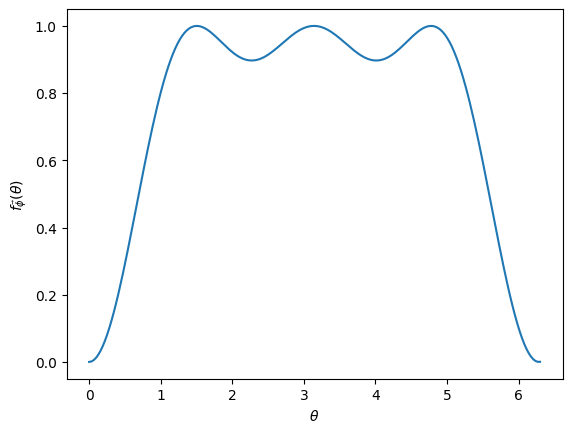

In [162]:
#Transition response function
# Want to find a vphi s.t. tprf(vphi, theta) ~= sigmoid(theta)
def tprf(vphi: List[float], theta: float):
    ket0, ket1 = np.array([1, 0]), np.array([0,1])
    return np.pow(np.abs(ket0.transpose().conj() @ ((eqang_U(vphi, theta)) @ ket1) ), 2)

x = np.linspace(0, 6.3, 200)
y = [tprf([0, 1.5, 0], theta) for theta in x]
plt.plot(x, y)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$f_{\vec{\phi}}(\theta)$')

We now have a way to plot and track the probability response function $f_{\vec{\phi}}(\theta)=|\bra{0} R_{\phi_0}(\theta)R_{\phi_1}(\theta)\cdots R_{\phi_N}(\theta)\ket{1}|^2$ and functions to return corresponding unitaries for both the composite gate and the individual equiangular gates.
# Modelling the Sigmoid
### Best-fit
Our goal is to create an objective function (derived from https://arxiv.org/pdf/2002.11649, although with some differences since there is less symmetry to using transition probability response function instead of the $Re(\bra{0} \hat U_\Phi(\theta)\ket{0})$) as follows:
$$ L(\Phi) = \frac{1}{d} \sum_{j=0}^d | |\bra{0}\hat U_\Phi(\theta_j)\ket{1} |^2 - \sigma(\theta_j) |^2 $$
where the points $\theta_j$ are from some set of numbers to normalize onto, it should be of length $L$. Chebyshev norm works, as does other ranges
This provides a heuristic of sorts from which we want to minimize as much as possible. We can thus use classical, numerical optimization methods that reduce the error as a function of $\Phi$.

In [210]:
from scipy.optimize import minimize

In [186]:
#Define the polynomial function
#Approximations seem to really throw it out of wack since it's not exactly odd/even.
sigmoid_taylor = [1/2, 1/4, 0, -1/48, 0, 1/480, 0, -17/80640, 0, 31/1451520]
sig_poly = np.polynomial.Polynomial(sigmoid_taylor)
sig_poly(-2)

np.float64(0.11604938271604937)

In [233]:
def objective_func(phiset: List[float], func, norm: List[float]):
    d = len(phiset)
    
    return (1 / d) * sum([ np.abs( tprf(phiset, xi) - func(xi) )**2 for xi in norm ])

In [234]:
#BFGS
def QSPBFGS(phi0: np.ndarray, func, tolerance: float, norm: List[float], restarts=3):
    obj_func = lambda PHI: objective_func(PHI, func, norm) # Isolate to just one input for scipy.minimize
    best_phi = phi0.copy() #hold a "best" phi
    best_err = obj_func(best_phi) #hold a min err
    
    for i in range(restarts):
        # Add slight noise to best to try and avoid deterministic local minima -> retrying the same thing can have varying best fits! try multiple times
        current_phi = best_phi + np.random.normal(0, 0.05, size=len(best_phi))
        res = minimize(obj_func, current_phi, method='l-bfgs-b',
                       tol=tolerance / 10,
                       options={'maxiter': 100000, 'maxfun': 100000})
        print("Iteration ", i, " complete.")
        if res.fun < best_err: # save best result / error
            best_err = res.fun
            best_phi = res.x
        if best_err <= tolerance: # if we're below threshold we can just break
            break
    
    return best_phi


This is a fairly efficient minimizer. There are some minor caveats to this method, however:
1. Experimentally, it seems best to use Polynomial approximations as the converge more quickly, which should align with the fact that there exists a polynomial $1-A(x)^2-B(x)^2$ that fully characterizes $f_{\vec \phi}(\theta)$ (the achievability).
2. Since it's a product of equiangular composite gates, by our formulation the composite gate $\hat U_\Phi (\theta)$ will always be 0 when $\theta = 0$, which again, should align with the fact that it would then just look like $|\bra{0}III...III\ket{1}|^2$, which very clearly will always be 0. Which,
3. Since $\sigma(0)$=0.5, any approximation will unfortunately struggle to do an immediate, sharp jump from 0 and then follow the sigmoid fitting, making it harder to adjust to the function correctly. Thus, we want to approximate the sigmoid shifted down by 0.5 so the curve is far less steep to approximate by fitting. However,
4. Since we use $\sigma(\theta) - 0.5$, all values of $\theta < 0$ will simply not be able to be fitted to correctly, since the response function is of the absolute square of a function, it cannot produce those negative values.
To solve these errors, we first hand-compute an approximation for $\sigma(\theta) - 0.5$, since approximate methods seem to throw it further away. <br>
We can also classicaly flip the sign on the input if <0, the flip the sign on the output since $\sigma(\theta) - 0.5$ is a perfectly odd function. Regardless of the input, we then again classically add 0.5, and we have a full approximation of $\sigma$ for relatively small $L$ (around 15 seems to work well). <br>
Let's try it on the basic shifted function. 

Iteration  0  complete.
Iteration  1  complete.
Iteration  2  complete.


Text(0, 0.5, '$y$')

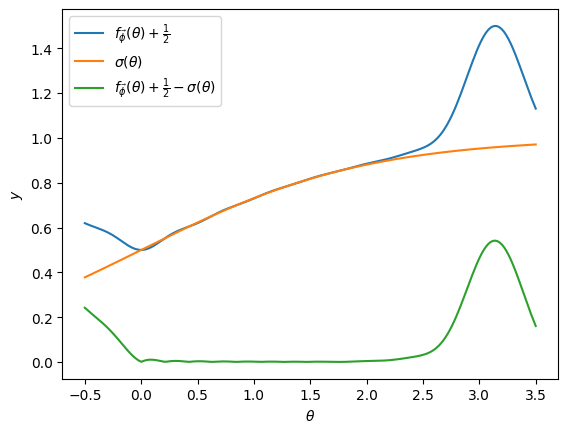

In [240]:
L = 15
phi0 = np.linspace(np.pi/4, -np.pi/4, L)

#Shifted function
res = QSPBFGS(phi0, lambda x: sig_poly(x) - 0.5, 0.000000001, np.linspace(0, 2.5, L))

x = np.linspace(-0.5, 3.5, 200)
y1 = [1 / 2 +tprf(res, theta) for theta in x] # Note that we are plotting the sigmoid(x) - 0.5 QSP approximation classicaly shifted upwards by 0.5 so it is just the sigma function
y2 = [1 / (1 + np.exp(-theta)) for theta in x]
y3 = [np.abs(y1[i] - y2[i]) for i in range(200)]
plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)
plt.legend([r'$f_{\vec{\phi}}(\theta) + \frac{1}{2}$', r'$\sigma(\theta)$', r'$|f_{\vec{\phi}}(\theta) + \frac{1}{2} - \sigma(\theta)|$' ])
plt.xlabel(r'$\theta$')


I would argue that we already have an incredibly powerful approximation for just $L=15$. For about $0 \leq \theta \leq 1$, our approximation (in the blue) is almost exactly the sigmoid (in the orange). The absolute difference between them, as plotted below, is effectively 0 for that range of $\theta$. There are still likely more optimizations to be made along with more degrees of freedom even in just what we've done so far. For more accuracy, you could fit to a larger space, [0, 3] for example, and increase $L$, although 15 for [0, ~2.5] feels like a very powerful approximation already. 

Iteration  0  complete.
Iteration  1  complete.
Iteration  2  complete.


Text(0.5, 0, '$\\theta$')

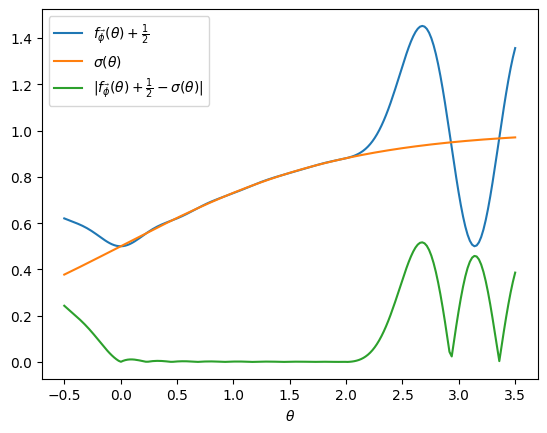

In [251]:
L = 16
phi0 = np.linspace(np.pi/4, -np.pi/4, L)

#Shifted function
res = QSPBFGS(phi0, lambda x: 1 / (1+np.exp(-x)) - 0.5, 0.000000001, np.linspace(0, 2, L))

x = np.linspace(-0.5, 3.5, 200)
y1 = [1 / 2 +tprf(res, theta) for theta in x] # Note that we are plotting the sigmoid(x) - 0.5 QSP approximation classicaly shifted upwards by 0.5 so it is just the sigma function
y2 = [1 / (1 + np.exp(-theta)) for theta in x]
y3 = [np.abs(y1[i] - y2[i]) for i in range(200)]
plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)
plt.legend([r'$f_{\vec{\phi}}(\theta) + \frac{1}{2}$', r'$\sigma(\theta)$', r'$|f_{\vec{\phi}}(\theta) + \frac{1}{2} - \sigma(\theta)|$' ])
plt.xlabel(r'$\theta$')
